As electronic vehicles (EVs) become more popular, there is an increasing need for access to charging stations, also known as ports. To that end, many modern apartment buildings have begun retrofitting their parking garages to include shared charging stations. A charging station is shared if it is accessible by anyone in the building.

The data has been loaded into a PostgreSQL database with a table named `charging_sessions` with the following columns:

## charging_sessions

| Column | Definition | Data type |
|-|-|-|
|`garage_id`| Identifier for the garage/building|`VARCHAR`|
|`user_id` | Identifier for the individual user|`VARCHAR`|
|`user_type`|Indicating whether the station is `Shared` or `Private`| `VARCHAR` |
|`start_plugin`|The date and time the session started |`DATETIME`|
|`start_plugin_hour`|The hour (in military time) that the session started | `NUMERIC`|
|`end_plugout`|The date and time the session ended | `DATETIME` |
|`end_plugout_hour`|The hour (in military time) that the session ended | `NUMERIC`|
|`duration_hours`| The length of the session, in hours|`NUMERIC`|
|`el_kwh`| Amount of electricity used (in Kilowatt hours)|`NUMERIC`|
|`month_plugin`| The month that the session started |`VARCHAR`|
|`weekdays_plugin`| The day of the week that the session started|`VARCHAR`|

#### Sources
- **Data**: (https://www.kaggle.com/datasets/anshtanwar/residential-ev-chargingfrom-apartment-buildings)

In [9]:
-- unique_users_per_garage
SELECT garage_id, 
	COUNT(DISTINCT user_id) AS num_unique_users
FROM charging_sessions
WHERE user_type = 'Shared'
GROUP BY garage_id
ORDER BY num_unique_users DESC;

,garage_id,num_unique_users
0,Bl2,18
1,AsO2,17
2,UT9,16
3,AdO3,3
4,MS1,2
5,SR2,2
6,AdA1,1
7,Ris,1


In [10]:
-- most_popular_shared_start_times
SELECT weekdays_plugin,
	start_plugin_hour, 
	COUNT(*) AS num_charging_sessions
FROM charging_sessions
WHERE user_type = 'Shared'
GROUP BY weekdays_plugin,
	start_plugin_hour
ORDER BY num_charging_sessions DESC
LIMIT 10;

,weekdays_plugin,start_plugin_hour,num_charging_sessions
0,Sunday,17,30
1,Friday,15,28
2,Thursday,19,26
3,Thursday,16,26
4,Wednesday,19,25
5,Sunday,18,25
6,Sunday,15,25
7,Monday,15,24
8,Friday,16,24
9,Tuesday,16,23


In [11]:
-- long_duration_shared_users
SELECT user_id, 
	AVG(duration_hours) as avg_charging_duration
FROM charging_sessions 
WHERE user_type = 'Shared' 
GROUP BY user_id
HAVING AVG(duration_hours) > 10
ORDER BY AVG(duration_hours) DESC;

,user_id,avg_charging_duration
0,Share-9,16.845833
1,Share-17,12.894556
2,Share-25,12.214475
3,Share-18,12.088807
4,Share-8,11.550431
5,AdO3-1,10.369387


In [15]:
-- avg_sessions_per_day 
SELECT 
    weekdays_plugin,
    COUNT(*) AS total_sessions,
    ROUND(COUNT(*) / COUNT(DISTINCT DATE(start_plugin)), 2) AS avg_sessions_per_day
FROM charging_sessions
WHERE user_type = 'Shared' 
GROUP BY weekdays_plugin
ORDER BY 
    CASE 
        WHEN weekdays_plugin = 'Monday' THEN 1
        WHEN weekdays_plugin = 'Tuesday' THEN 2
        WHEN weekdays_plugin = 'Wednesday' THEN 3
        WHEN weekdays_plugin = 'Thursday' THEN 4
        WHEN weekdays_plugin = 'Friday' THEN 5
        WHEN weekdays_plugin = 'Saturday' THEN 6
        WHEN weekdays_plugin = 'Sunday' THEN 7
    END;

,weekdays_plugin,total_sessions,avg_sessions_per_day
0,Monday,204,4.0
1,Tuesday,178,3.0
2,Wednesday,169,3.0
3,Thursday,220,4.0
4,Friday,206,3.0
5,Saturday,175,3.0
6,Sunday,260,4.0


In [16]:
-- peak demand hours
SELECT 
    weekdays_plugin,
    start_plugin_hour,
    COUNT(*) AS session_count
FROM charging_sessions
WHERE user_type = 'Shared' 
GROUP BY weekdays_plugin, start_plugin_hour
ORDER BY 
    CASE 
        WHEN weekdays_plugin = 'Monday' THEN 1
        WHEN weekdays_plugin = 'Tuesday' THEN 2
        WHEN weekdays_plugin = 'Wednesday' THEN 3
        WHEN weekdays_plugin = 'Thursday' THEN 4
        WHEN weekdays_plugin = 'Friday' THEN 5
        WHEN weekdays_plugin = 'Saturday' THEN 6
        WHEN weekdays_plugin = 'Sunday' THEN 7
    END,
    start_plugin_hour;

,weekdays_plugin,start_plugin_hour,session_count
0,Monday,0,4
1,Monday,1,1
2,Monday,5,1
3,Monday,7,2
4,Monday,8,6
...,...,...,...
130,Sunday,19,18
131,Sunday,20,11
132,Sunday,21,16
133,Sunday,22,9


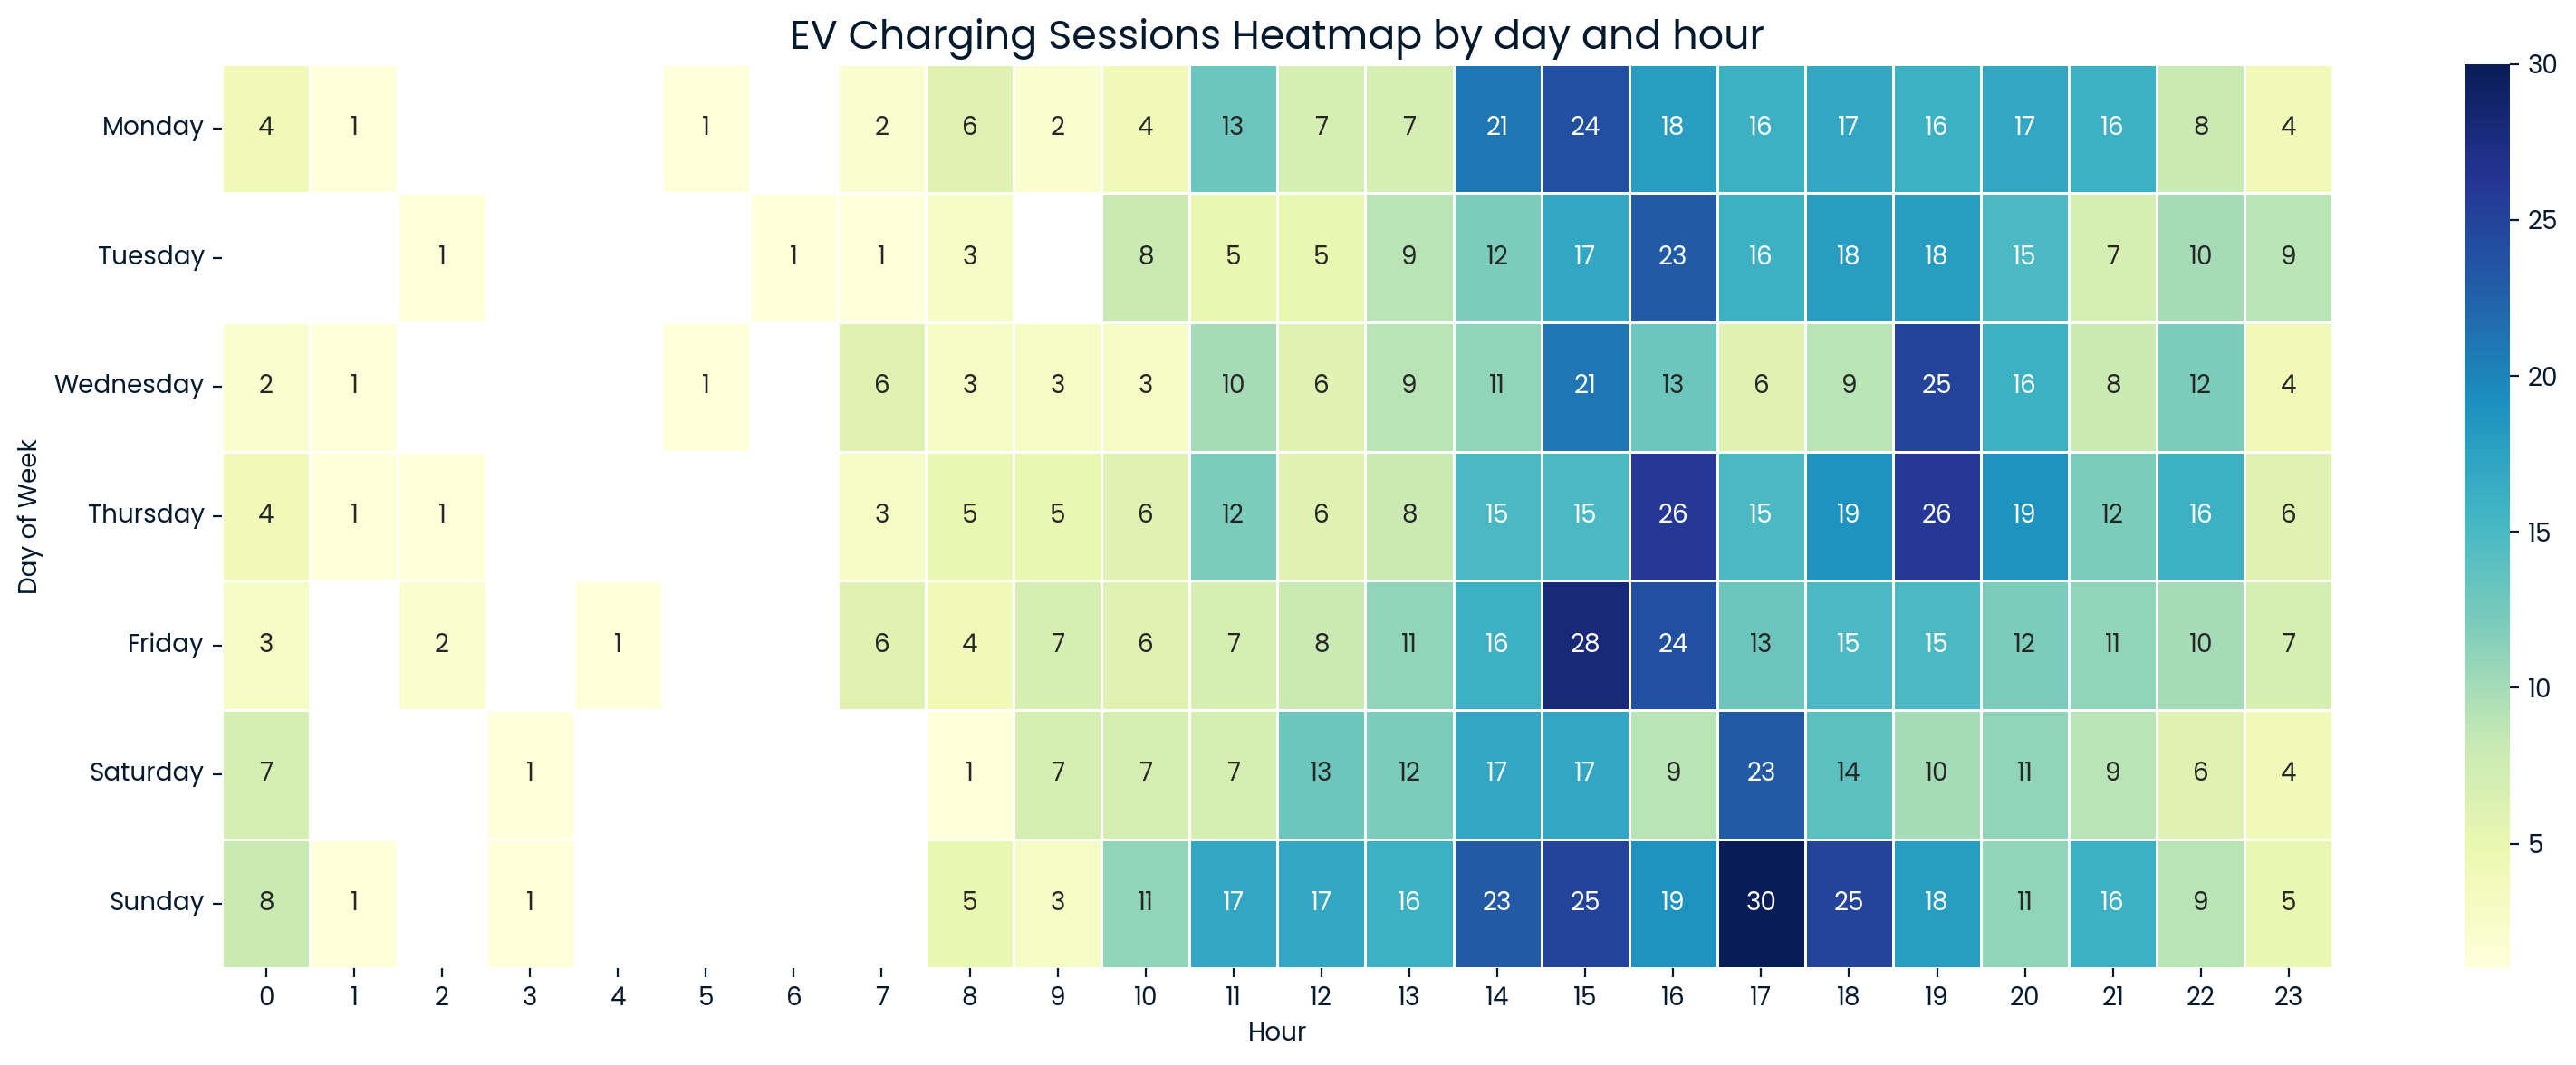

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df1['weekdays_plugin'] = pd.Categorical(df1['weekdays_plugin'], categories=day_order, ordered=True)

heatmap_data = df1.pivot(index='weekdays_plugin', columns='start_plugin_hour', values='session_count')

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='g', linewidths=0.5)
plt.title("EV Charging Sessions Heatmap by day and hour", fontsize=16)
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()